# Quick start and general recommendations
This notebook provides a brief introduction to `bayes_drt` and general recommendations for best results. For more detail, see the in-depth tutorials.

The example below demonstrates the basic process of fitting the distribution of relaxation times (DRT) or diffusion times (DDT) to impedance data and anlayzing the results:  
1. Fit the distribution (DRT or DDT)
1. Visualize results using built-in plotting methods
1. Perform a peak fit to quantify discrete contributions to the DRT

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import time
import matplotlib.pyplot as plt
%matplotlib notebook
import glob

from bayes_drt.inversion import Inverter
import bayes_drt.file_load as fl
import bayes_drt.plotting as bp

%load_ext autoreload
%autoreload 2

"""
NOTE: the first time you import bayes_drt.inversion, several models will be compiled, which will take a significant
amount of time (typically ~20 minutes). Once compiled, the model files will be stored with the package,
such that this step will only be necessary the first time you import the package.
"""

'\nNOTE: the first time you import bayes_drt.inversion, several models will be compiled, which will take a significant\namount of time (typically ~20 minutes). Once compiled, the model files will be stored with the package,\nsuch that this step will only be necessary the first time you import the package.\n'

In [2]:
# Set plot formatting and data directory
datadir = '../data'

tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

# 1. Fitting the DRT

This example uses data simulated from an equivalent circuit model consisting of an ohmic resistor, an RC element, and a ZARC element in series. The following subsections demonstrate the fitting and analysis process.

## 1a. Perform the fit

Here, we create an `Inverter` instance and use it to fit the simulated data. The `Inverter` class contains all the core functionality of `bayes_drt`: methods for fitting, visualization, and peak fitting. Below, we create two `Inverter` instances (one for MAP optimization, one for HMC sampling) and use the `fit` method to fit each instance to the data.

<IPython.core.display.Javascript object>


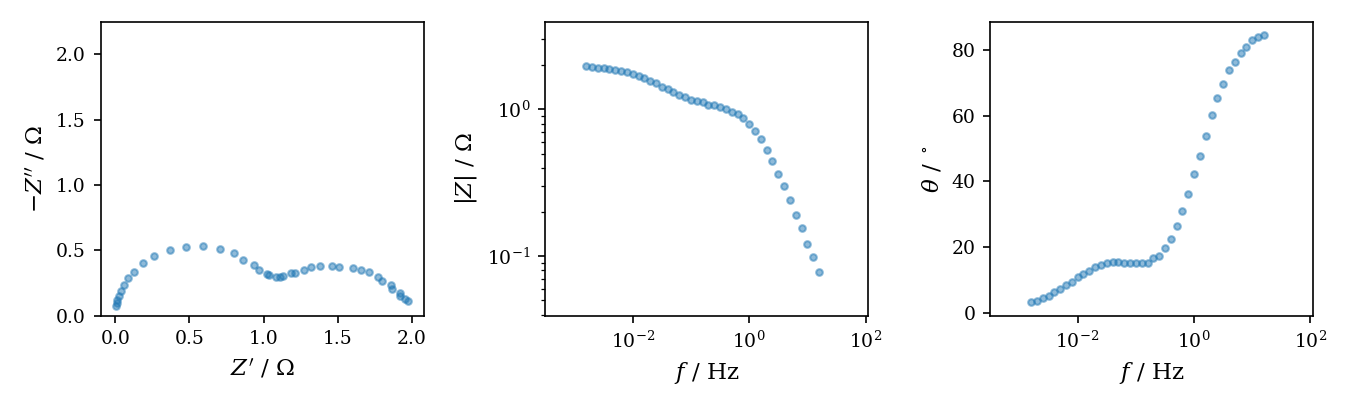

In [7]:
"Load data"
# load simulated impedance data with noise
Z_file = os.path.join(datadir,'simulated','Z_RC-ZARC_Macdonald_0.25.csv')
Zdf = pd.read_csv(Z_file)

# load true DRT
g_file = os.path.join(datadir,'simulated','gamma_RC-ZARC.csv')
g_true = pd.read_csv(g_file)

# extract frequency and complex impedance
freq, Z = fl.get_fZ(Zdf)

# Plot the data
axes = bp.plot_eis(Zdf)

In [45]:
"Fit the data"
# By default, the Inverter class is configured to fit the DRT (rather than the DDT)
# Create separate Inverter instances for HMC and MAP fits
# Set the basis frequencies equal to the measurement frequencies (not necessary in general, but yields faster results here)
inv_hmc = Inverter(basis_freq=freq)
inv_map = Inverter(basis_freq=freq)

# Perform HMC fit
start = time.time()
inv_hmc.fit(freq, Z, mode='sample')
elapsed = time.time() - start
print('HMC fit time {:.1f} s'.format(elapsed))

# Perform MAP fit
start = time.time()
inv_map.fit(freq, Z, mode='optimize')  # initialize from ridge solution
elapsed = time.time() - start
print('MAP fit time {:.1f} s'.format(elapsed))

HMC fit time 81.1 s
MAP fit time 2.0 s


Fitting with MAP optimization (`mode='optimize'`, the default option) is typically an order of magnitude faster than HMC sampling (`mode='sample'`). The MAP result almost always matches the HMC mean very closely. I would recommend using MAP optimization as your primary tool for analysis, and using HMC sampling only when you need the credible interval.

## 1b. Visualize the results

Here we use the built-in plotting methods in the `Inverter` class to visualize the fitting results. First, let's check the estimated DRT and the corresponding fit of the impedance data using the built-in methods `plot_distribution` and `plot_fit`.

<IPython.core.display.Javascript object>


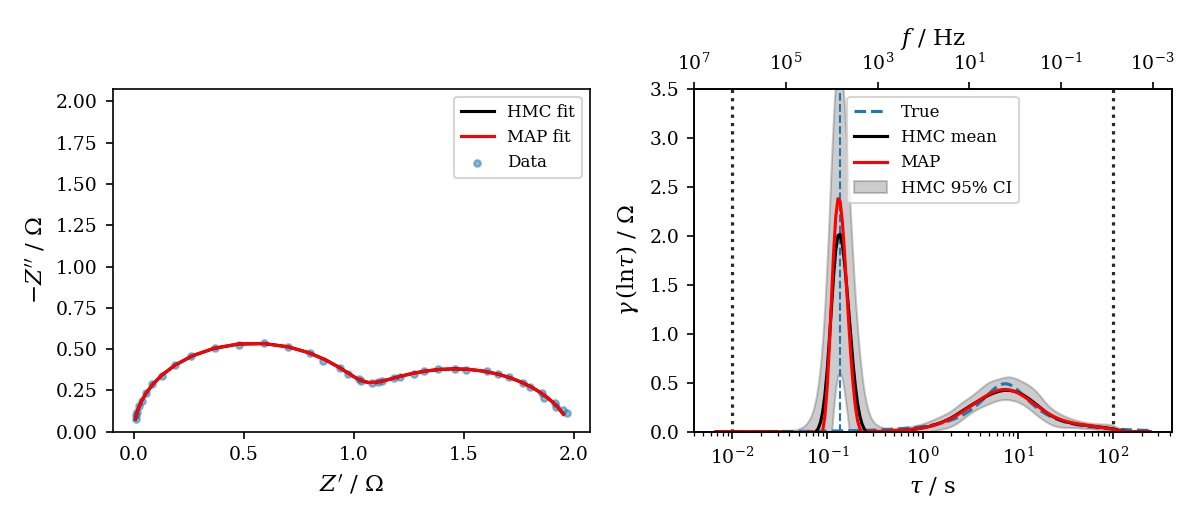

In [54]:
"Visualize DRT and impedance fit"
# plot impedance fit and recovered DRT
fig,axes = plt.subplots(1, 2, figsize=(8, 3.5))

# plot fits of impedance data
inv_hmc.plot_fit(axes=axes[0], plot_type='nyquist', color='k', label='HMC fit', data_label='Data')
inv_map.plot_fit(axes=axes[0], plot_type='nyquist', color='r', label='MAP fit', plot_data=False)

# plot true DRT
p = axes[1].plot(g_true['tau'],g_true['gamma'],label='True',ls='--')
# add Dirac delta function for RC element
axes[1].plot([np.exp(-2),np.exp(-2)],[0,10],ls='--',c=p[0].get_color(),lw=1)

# Plot recovered DRT at given tau values
tau_plot = g_true['tau'].values
inv_hmc.plot_distribution(ax=axes[1], tau_plot=tau_plot, color='k', label='HMC mean', ci_label='HMC 95% CI')
inv_map.plot_distribution(ax=axes[1], tau_plot=tau_plot, color='r', label='MAP')

axes[1].set_ylim(0,3.5)
axes[1].legend()


fig.tight_layout()

The HMC result produces a distribution of possible DRTs, which is visualized above using both the mean (black line) and the 95% credible interval (CI, gray region). The MAP fit produces a point estimate of the DRT, which is indicated by the red line. The HMC mean lies precisely underneath the MAP estimate over most of the $\tau$ range in the above DRT plot. The HMC and MAP fits produce virtually identical impedance fits.

Next, we can check the residuals and the estimated error structure of the data using the method `plot_residuals`.

<IPython.core.display.Javascript object>


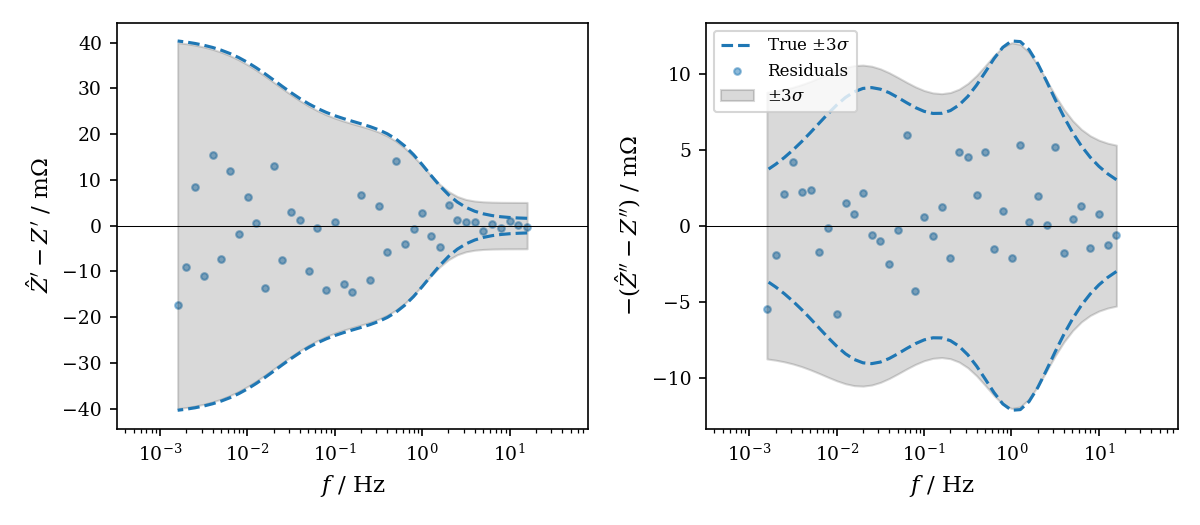

In [51]:
"Visualize the recovered error structure"
# For visual clarity, only MAP results are shown.
# HMC results can be obtained in the same way
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), sharex=True)

# plot residuals and estimated error structure
inv_map.plot_residuals(axes=axes)

# plot true error structure in miliohms
p = axes[0].plot(freq, 3*Zdf['sigma_re'] * 1000, ls='--')
axes[0].plot(freq, -3*Zdf['sigma_re'] * 1000, ls='--', c=p[0].get_color())
axes[1].plot(freq, 3*Zdf['sigma_im'] * 1000, ls='--')
axes[1].plot(freq, -3*Zdf['sigma_im'] * 1000, ls='--', c=p[0].get_color(), label='True $\pm 3\sigma$')

axes[1].legend()

fig.tight_layout()

The estimated error structure is fairly accurate; it slightly overpredicts the imaginary error scale at low frequencies.

You can also produce a full set of diagnostic plots using the method `plot_full_results`, as shown below.

<IPython.core.display.Javascript object>


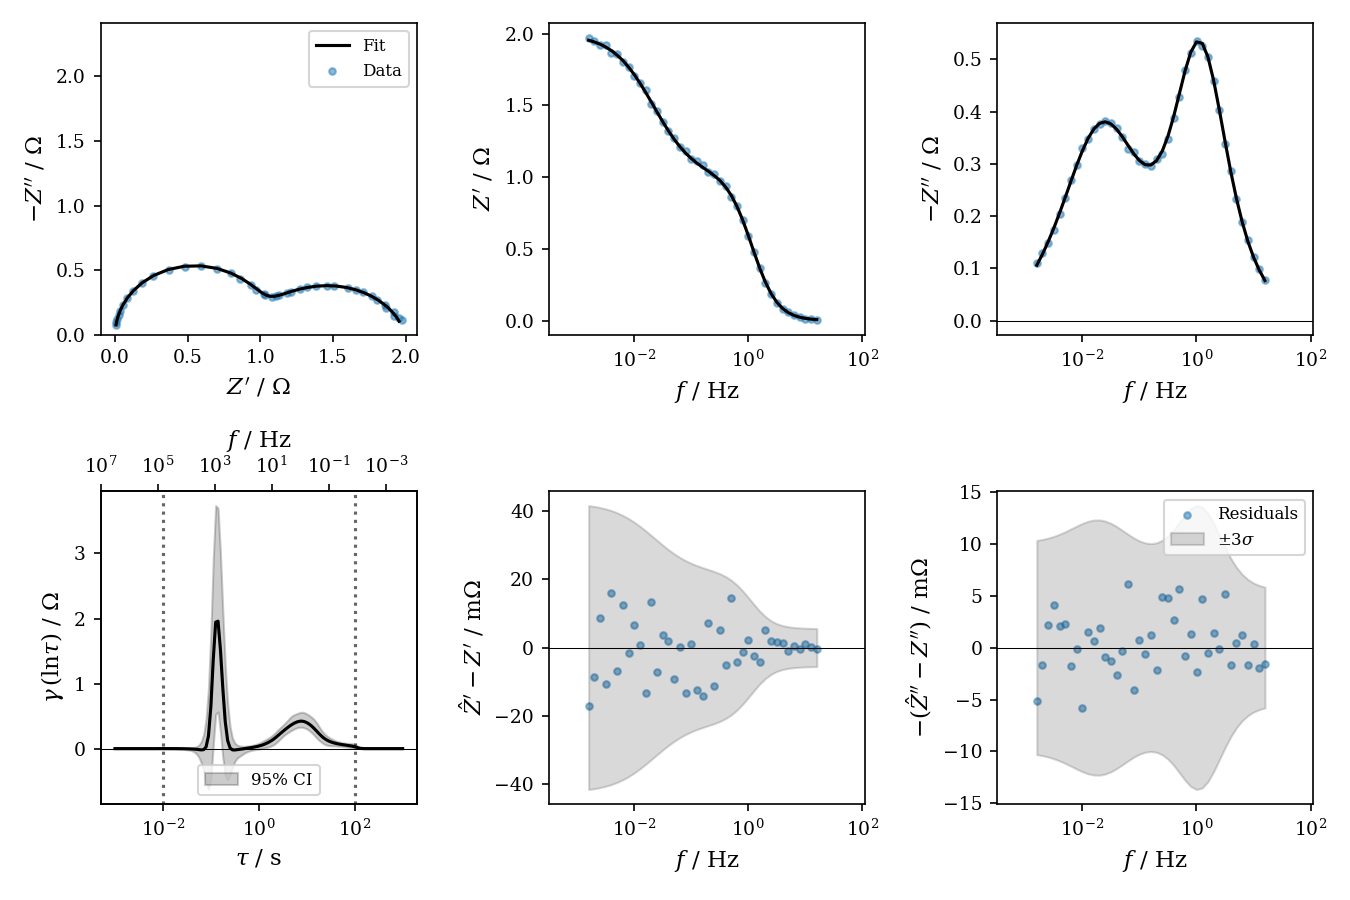

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000213B4808048>,
      dtype=object)

In [58]:
inv_hmc.plot_full_results()

In [59]:
"Get the polarization resistance, ohmic resistance, and inductance"
# Results are shown for HMC only, but can be obtained for the MAP fit in the same way.
# The only difference is that the MAP fit does not provide percentile prediction.
print('R_inf: {:.4f} ohms'.format(inv_hmc.R_inf))
print('Inductance: {:.4e} H'.format(inv_hmc.inductance))
print('Polarization resistance: {:.4f} ohms'.format(inv_hmc.predict_Rp()))
print('Rp 2.5 percentile: {:.4f} ohms'.format(inv_hmc.predict_Rp(percentile=2.5)))
print('Rp 97.5 percentile: {:.4f} ohms'.format(inv_hmc.predict_Rp(percentile=97.5)))

R_inf: 0.0017 ohms
Inductance: 1.0039e-05 H
Polarization resistance: 1.9803 ohms
Rp 2.5 percentile: 1.9732 ohms
Rp 97.5 percentile: 1.9873 ohms


The true values for $R_\infty$, $L$, and $R_p$ are 0 $\Omega$, 0 H, and 2 $\Omega$, respectively. The estimates for $R_\infty$ and $R_p$ are accurate, but the inductance estimate is somewhat high. However, because the measured frequency range captures only relatively low frequencies, inductive effects are hard to estimate.

## 1c: Perform a peak fit
Next, we can use `fit_peaks` to fit a series of Havriliak-Negami (HN) peaks to the DRT. This method usually works fairly well with the default settings, but in some cases issues can arise due to shape mismatches or tiny peaks in the DRT. For this example, the sharpness of the first peak and slight distortion of the second peak cause some issues with peak fitting (in my experience, this is rare with experimental data). We can try a few things to address this: first, we can exclude small peaks by setting a peak prominence threshold.

<IPython.core.display.Javascript object>


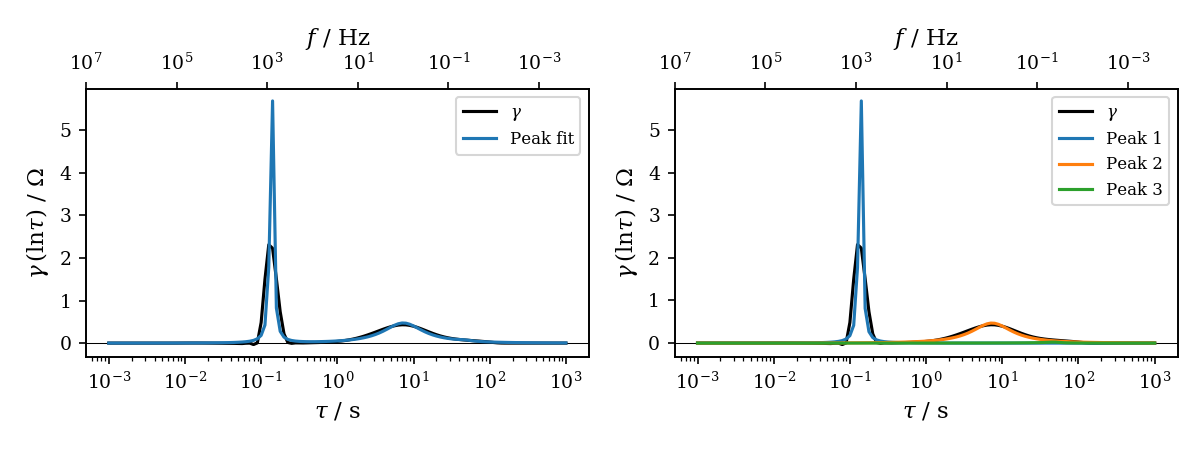

In [167]:
# Only fit peaks that have a prominence of >= 5% of the estimated polarization resistance
inv_map.fit_peaks(prom_rthresh=0.05)

# plot the peak fit
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
inv_map.plot_peak_fit(ax=axes[0])  # Plot the overall peak fit
inv_map.plot_peak_fit(ax=axes[1], plot_individual_peaks=True)  # Plot the individual peaks

fig.tight_layout()

In [161]:
# Extract the peak parameters
inv_map.extract_peak_info()

{'num_peaks': 3,
 'chi_sq': 1.1678629794621258,
 'R': array([1.13215675, 0.92250437, 0.02615853]),
 'tau_0': array([ 0.13754626,  7.33761992, 49.78863025]),
 'alpha': array([1.        , 1.        , 0.71157454]),
 'beta': array([0.9842121 , 0.80751692, 0.93269987])}

We can see that the two true peaks are fitted reasonably well, but an additional (false) shoulder peak was fitted at low frequency ($\tau \approx 50$ s). We could get rid of this false peak by further increasing `prom_rthresh`, but in practice we will often end up losing both true peaks and false peaks from our peak fit by doing this. Instead, we can specify the approximate time constants of the peaks that we want to fit and use the `fit_peaks_constrained` method to fit only those peaks.

<IPython.core.display.Javascript object>


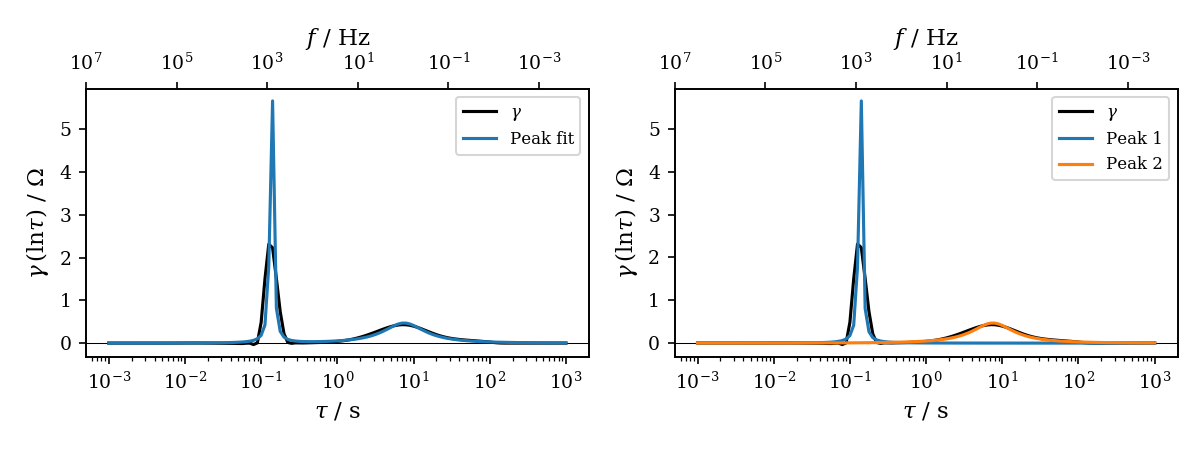

In [168]:
# Perform peak fit from approximate time constants
tau0_guess = [0.1, 10]  # specify time constant guesses - these can be rough
inv_map.fit_peaks_constrained(tau0_guess)

# plot the peak fit
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
inv_map.plot_peak_fit(ax=axes[0])  # Plot the overall peak fit
inv_map.plot_peak_fit(ax=axes[1], plot_individual_peaks=True)  # Plot the individual peaks

fig.tight_layout()

In [165]:
# Extract the peak parameters
inv_map.extract_peak_info()

{'num_peaks': 2,
 'chi_sq': 1.1768501249759948,
 'R': array([1.13120117, 0.94875736]),
 'tau_0': array([0.13749252, 7.52398589]),
 'alpha': array([1., 1.]),
 'beta': array([0.98426684, 0.80189782])}

We now have a good fit that includes only the two true peaks. The entries that are produced by `extract_peak_info` have the following meanings:
* `num_peaks`: number of peaks resulting from the peak fit
* `chi_sq`: goodness of fit for the peak fit
* `R`: peak magnitudes, sorted by ascending time constant
* `tau_0`: peak time constants, sorted ascending
* `alpha`: peak symmetry parameters (1 indicates symmetric, <1 indicates asymmetric), sorted by ascending time constant
* `beta`: peak dispersion parameters (1 indicates ideal, <1 indicates dispersed), sorted by ascending time constant

# Fitting the DDT
This example demonstrates recovery of the distribution of diffusion times (DDT, see https://doi.org/10.1103/PhysRevLett.120.116001). The process is identical to the DRT fitting process, except that the desired distribution must be defined explicitly when creating the `Inverter` object. For this example, we use data simulated with noise from a bimodal DDT with transmissive boundary conditions and planar symmetry.

*Note: the DDT model has not been developed and validated to the same extent as the DRT model. Results for DDT recovery are typically less reliable than those for DRT recovery, as illustrated below.*

<IPython.core.display.Javascript object>


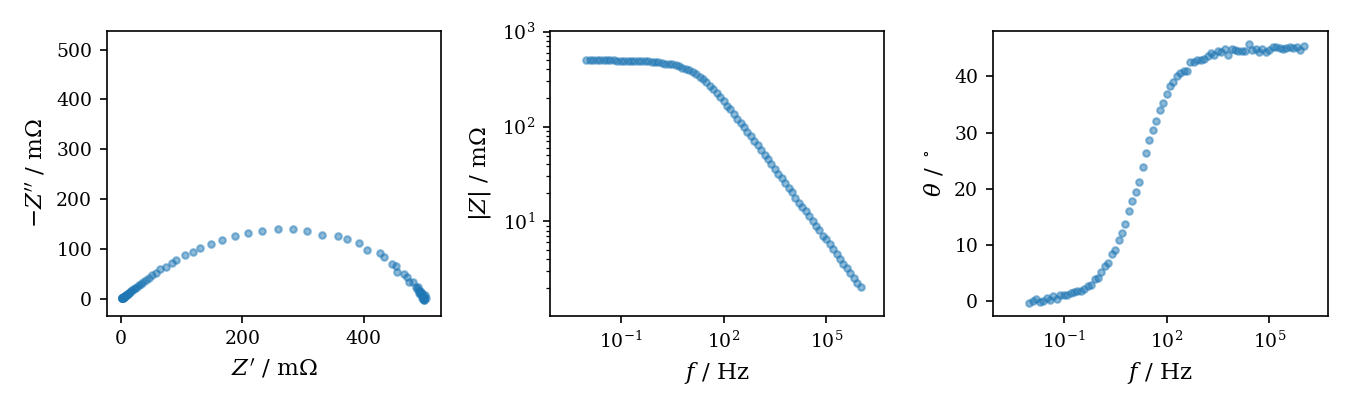

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000213C2C005C8>,
      dtype=object)

In [170]:
"Load data"
# load simulated impedance data with noise
Z_file = os.path.join(datadir,'simulated','Z_BimodalTP-DDT_Orazem_0.25.csv')
Zdf = pd.read_csv(Z_file)

# load true DDT
g_file = os.path.join(datadir,'simulated','gamma_BimodalTP-DDT.csv')
g_true = pd.read_csv(g_file)

# extract frequency and complex impedance
freq, Z = fl.get_fZ(Zdf)

# plot the data
bp.plot_eis(Zdf)

In [180]:
"Fit the data"
# Define the distribution to be recovered (transmissive planar DDT) in the Inverter initialization
# Use a slightly expanded basis frequency range to fully capture the tail of the low-frequency peak
inv_hmc2 = Inverter(distributions={'DDT':{'kernel':'DDT','dist_type':'parallel','bc':'transmissive',
                                         'symmetry':'planar','basis_freq':np.logspace(6,-3,91)}
                                 }
                  )
inv_map2 = Inverter(distributions={'DDT':{'kernel':'DDT','dist_type':'parallel','bc':'transmissive',
                                         'symmetry':'planar','basis_freq':np.logspace(6,-3,91)}
                                 }
                  )

# # Perform HMC fit
start = time.time()
inv_hmc2.fit(freq, Z, mode='sample')
elapsed = time.time() - start
print('HMC fit time {:.2f}'.format(elapsed))

# Perform MAP fit
start = time.time()
inv_map2.fit(freq, Z)
elapsed = time.time() - start
print('MAP fit time {:.2f}'.format(elapsed))

c:\users\jdh10\onedrive - colorado school of mines\python\projects\bayes_drt\bayes_drt\matrices.py:92: RuntimeWarning: overflow encountered in tanh
  return np.tanh(x) / x
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


HMC fit time 97.28
MAP fit time 1.65


<IPython.core.display.Javascript object>


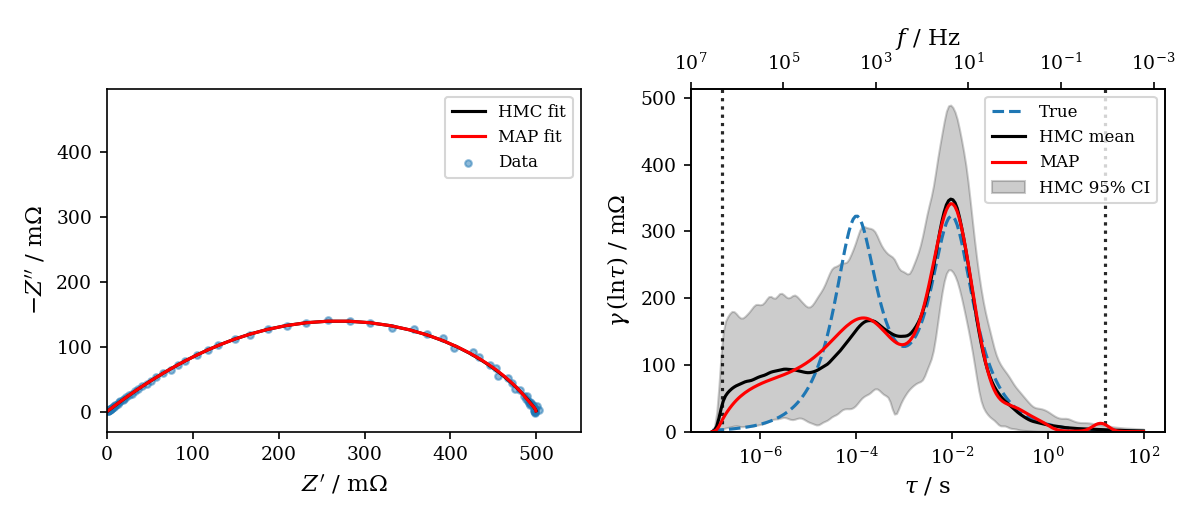

In [185]:
"Visualize DDT and impedance fit"
# plot impedance fit and recovered DRT
fig,axes = plt.subplots(1, 2, figsize=(8, 3.5))

# plot fits of impedance data
inv_hmc2.plot_fit(axes=axes[0], plot_type='nyquist', color='k', label='HMC fit', data_label='Data')
inv_map2.plot_fit(axes=axes[0], plot_type='nyquist', color='r', label='MAP fit', plot_data=False)

# plot true DRT
p = axes[1].plot(g_true['tau'], g_true['gamma']*1000, label='True', ls='--')

# Plot recovered DRT at given tau values
tau_plot = g_true['tau'].values
inv_hmc2.plot_distribution(ax=axes[1], tau_plot=tau_plot, color='k', label='HMC mean', ci_label='HMC 95% CI')
inv_map2.plot_distribution(ax=axes[1], tau_plot=tau_plot, color='r', label='MAP')

axes[1].legend()

fig.tight_layout()

The estimated DDT accurately captures the long-timescale peak, but recovers the short-timescale peak relatively poorly. While these results are suboptimal, this seems to be typical for DDT recovery - features at shorter timescales are often poorly recovered because they have less influence on the impedance. This result actually compares favorably to results using other DDT recovery methods.

<IPython.core.display.Javascript object>


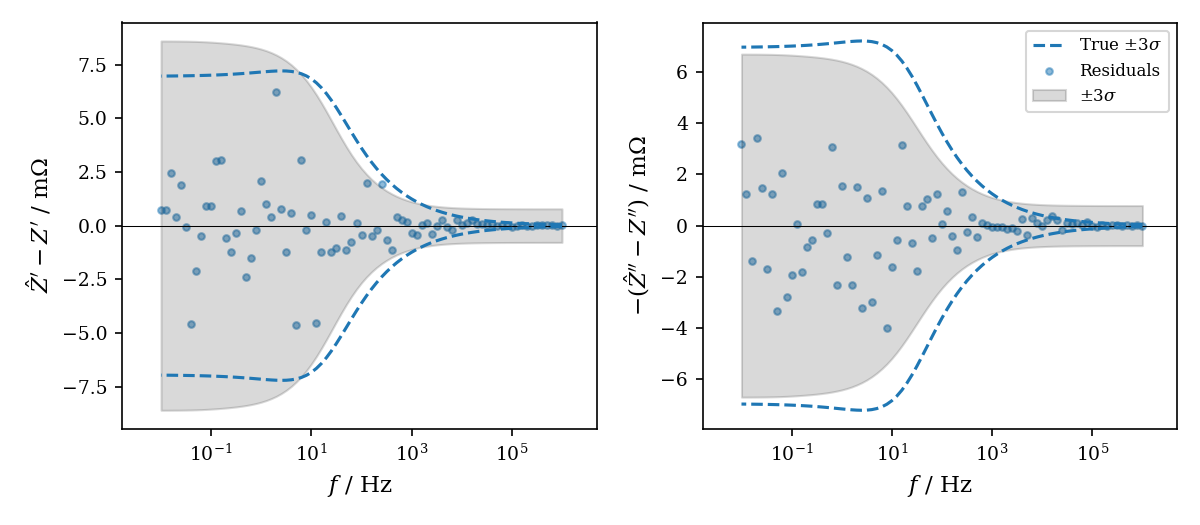

In [186]:
"Visualize the recovered error structure"
# For visual clarity, only MAP results are shown.
# HMC results can be obtained in the same way
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), sharex=True)

# plot residuals and estimated error structure
inv_map2.plot_residuals(axes=axes)

# plot true error structure in miliohms
p = axes[0].plot(freq, 3*Zdf['sigma_re'] * 1000, ls='--')
axes[0].plot(freq, -3*Zdf['sigma_re'] * 1000, ls='--', c=p[0].get_color())
axes[1].plot(freq, 3*Zdf['sigma_im'] * 1000, ls='--')
axes[1].plot(freq, -3*Zdf['sigma_im'] * 1000, ls='--', c=p[0].get_color(), label='True $\pm 3\sigma$')

axes[1].legend()

fig.tight_layout()

The recovered error structure is reasonably accurate.

In [188]:
"Get the polarization resistance, ohmic resistance, and inductance"
# Results are shown for HMC only, but can be obtained for the MAP fit in the same way.
# The only difference is that the MAP fit does not provide percentile prediction.
print('R_inf: {:.4f} ohms'.format(inv_hmc2.R_inf))
print('Inductance: {:.4e} H'.format(inv_hmc2.inductance))
print('Polarization resistance: {:.4f} ohms'.format(inv_hmc2.predict_Rp()))
print('Rp 2.5 percentile: {:.4f} ohms'.format(inv_hmc2.predict_Rp(percentile=2.5)))
print('Rp 97.5 percentile: {:.4f} ohms'.format(inv_hmc2.predict_Rp(percentile=97.5)))

R_inf: 0.0000 ohms
Inductance: 2.2885e-11 H
Polarization resistance: 0.4999 ohms
Rp 2.5 percentile: 0.4984 ohms
Rp 97.5 percentile: 0.5015 ohms


The estimates for $R_\infty$, $L$, and $R_p$ are very accurate - the true values are 0 $\Omega$, 0 H, and 0.5 $\Omega$, respectively.

# Fitting multiple distributions
It is also possible to fit multiple distributions simultaneously. For example, an impedance spectrum may arise from a relaxation process in series with a diffusive process; we would want to fit this spectrum using both a DRT and a DDT. This is a more involved process and is thus not covered here. See the detailed tutorial on multi-distribution recovery.

# General recommendations

* **Use `fit` with `mode='optimize'` (the default) for fast, accurate results.** It typically runs an order of magnitude faster than `bayes_fit` with comparable results, and is great for testing things before investing the time in `bayes_fit`.
* **Run `fit` with `nonneg=False` (the default) for best stability and recovery of sharp peaks; run with `nonneg=True` for faster results if you know your data does not contain negative DRT peaks.** The method is generally robust to undesired zero crossings and tends to produce good results without a constraint on the sign of the DRT. Enforcing a non-negativity constraint is usually unnecessary, although it does speed up the fitting process. In rare cases setting `nonneg=True` appears to cause sampling/optimization issues.
* **Run `fit` with `init_from_ridge=True` for the most consistent results.** This will use a fast (<0.5 s) ridge solution to initialize the model parameters, rather than using random values. This can yield faster results and in some cases helps avoid local minima.
* **If the impedance response is truncated (i.e. you can only see a partial semicircle/arc in the Nyquist plot), use an expanded basis frequency range to capture the full DRT.** When you fit an `Inverter` instance, the instance will automatically set the basis frequencies to extend one decade beyond the measured frequency range in each direction (provided that you did not set `basis_freq` manually at initialization). This generally works well, but you may want to adjust the basis frequency range depending on your data. If you use a larger range than necessary, the fit will take longer, but the results will generally be valid (it's possible that you'll end up with pseudo-peaks, but you can avoid this by setting `init_from_ridge=True`). If you use too small of a range, the model will not be able to fit the data. See the Extrapolation tutorial for an example.
* **If you're using a custom basis frequency range, make sure to use a spacing of 10 points per decade (ppd) for best results**, even if the measurement has a different frequency spacing. You can do this easily by specifying `basis_freq=np.logspace(b, a, int(10*(b - a) + 1))` where the highest and lowest basis frequencies are $10^b$ and $10^a$, respectively. The model is calibrated for a 10 ppd mesh and may produce unexpected results with different spacings.
* **Reuse the same `Inverter` instance to run multiple fits with the same measurement and basis frequencies.** This will save you some time on matrix calculations.
* **Use the `save_fit_data` and `load_fit_data` methods to save your fits.** You can save a fitted `Inverter` instance to a file for later use without having to re-run fits. This is especially handy for batch fitting.
* **Use DDT and multi-distribution recovery with caution.** These features are still somewhat experimental and may not behave as expected in all cases. Multi-distribution fitting seems to work best with `nonneg=True`.

If you encounter any problems, please feel free to report an issue or reach out. Happy fitting!